# Currency exchange rate trends analyzer

### Trend analysis for EURPLN exchange rates using data from 2013.09.09 to 2016.09.05 time period

In [278]:
# customarilily import most important libraries

import pandas as pd                       # pandas is a dataframe library
import matplotlib.pyplot as plt           # matplotlib.pyplot plots data
import numpy as np                        # numpy provides N-dim object support

import matplotlib.dates as mdates 
import math
import urllib.request
import io

# do ploting inline instead of in a separate window
%matplotlib inline

In [279]:
currency_symbol = 'EUR'
start_date = '2015-09-14'
end_date = '2016-09-13'

url_template = ("http://www.bankier.pl/narzedzia/archiwum-kursow-walutowych/get_answer?"
                "op=4&cur_symbol={}&start_dt={}&end_dt={}&customs=0"
                "&table_name=0&fromDay=0&monthDay=1&avg=0&avg_type=1&idTable=gemiusHitSection16")

# use static file to perform analysis
#url = './data-archive/EUR_2013.09.09_2016.09.05.csv'
#df = pd.read_csv(url, sep=';')     # load data
#
# or get latest data
url = url_template.format(currency_symbol, start_date, end_date)

with urllib.request.urlopen(url) as response:
    content = unicode(response.read(), errors='ignore')

# remove unnecessary header and footers
content_lines = content.splitlines()[2:-4]
content = '\n'.join(content_lines)

df = pd.read_csv(io.StringIO(content), sep=';')     # load data

In [280]:
# get brief statistics over data we just read
df_columns, df_rows = df.shape

print("File contains {} rows and {} columns of data.".format(df_columns, df_rows))

File contains 253 rows and 4 columns of data.


#### Show first 3 rows from file

In [281]:
df.head(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
0,2016-09-12,4.3460,0.45,176/A/NBP/2016
1,2016-09-09,4.3264,0.33,175/A/NBP/2016
2,2016-09-08,4.3122,-0.39,174/A/NBP/2016


#### Show last 3 rows from file

In [282]:
df.tail(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
250,2015-09-16,4.1994,-0.24,180/A/NBP/2015
251,2015-09-15,4.2094,0.01,179/A/NBP/2015
252,2015-09-14,4.2090,0.02,178/A/NBP/2015


As we can see, data are not ordered chronologically. We must reverse the order of rows so that first row is the oldest, last row is the newest.

In [283]:
df = df.sort_index(axis=0, ascending=True)
df = df.iloc[::-1]
df.head(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
252,2015-09-14,4.2090,0.02,178/A/NBP/2015
251,2015-09-15,4.2094,0.01,179/A/NBP/2015
250,2015-09-16,4.1994,-0.24,180/A/NBP/2015


In [284]:
df.tail(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
2,2016-09-08,4.3122,-0.39,174/A/NBP/2016
1,2016-09-09,4.3264,0.33,175/A/NBP/2016
0,2016-09-12,4.3460,0.45,176/A/NBP/2016


Data frame (rows) is reversed now, which we can prove by observing values on the diagram

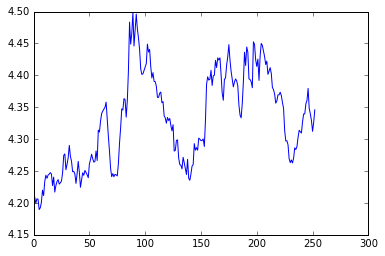

In [285]:
plt.plot(df['Kurs'].values)

### SMA - simple moving average

In [286]:
# an example on how to calculate SMA for a collection of data
v = {'score': [1, 2, 2, 3, 3, 4]}
data_frame = pd.DataFrame(v)
pd.rolling_mean(data_frame, 2)

,score
0,NaN
1,1.5
2,2.0
3,2.5
4,3.0
5,3.5


#### Calculate various SMA 

In order to perform better analysis, we will use recent data

In [287]:
# get last 100 exchange rates
last_days_to_analyze = 300
last_days_to_observe = 200

recent_exchange_rates = df['Kurs'].values[-last_days_to_analyze:]
recent_dates = df['Data'].values[-last_days_to_analyze:]

In [288]:
# create new DataFrame containing exchange rates ordered chronologically (oldest first, newest last)
df_exchange_rates = pd.DataFrame(recent_exchange_rates)

# define SMA windows (for short-term trading)
sma_windows = [3, 5, 7, 10, 20, 50]

# calculate SMA-3, SMA-5 and so on..
df_sma = {}
for window in sma_windows:
    df_sma[window] = pd.rolling_mean(df_exchange_rates, window)

In [289]:
# get data for last days we are interested in
recent_exchange_rates = recent_exchange_rates[-last_days_to_observe:]
recent_dates = recent_dates[-last_days_to_observe:]

#### Plot exchange rates along with different SMA

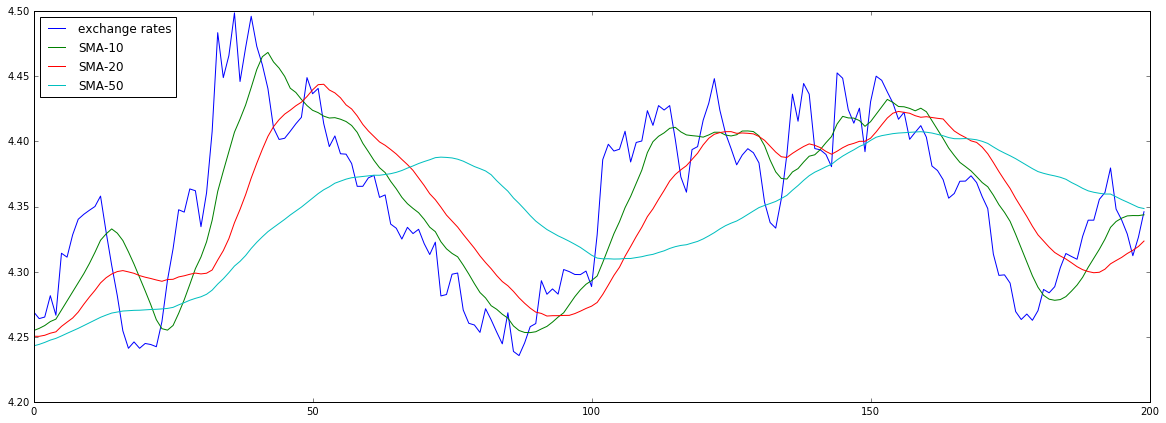

In [290]:
plt.figure(figsize=(20,7))

plt.plot(recent_exchange_rates)
# sma-10
plt.plot(df_sma[10][-last_days_to_observe:].values)
# sma-20
plt.plot(df_sma[20][-last_days_to_observe:].values)
# sma-50
plt.plot(df_sma[50][-last_days_to_observe:].values)

plt.legend(['exchange rates', 'SMA-10', 'SMA-20', 'SMA-50'], loc='upper left')

### Example on how to find points where the curves intersect

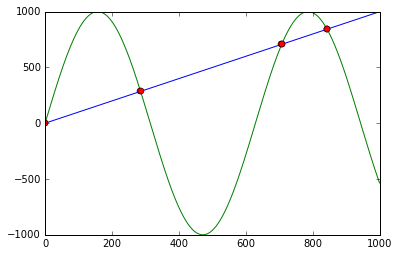

In [291]:

x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01)) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.isclose(f, g, atol=10)).reshape(-1)
plt.plot(x[idx], f[idx], 'ro')
plt.show()

Comment: This way of finding intersection point did not prove to be good in our special case

#### Let's analyze which SMA is the best in terms of mirroring trend 

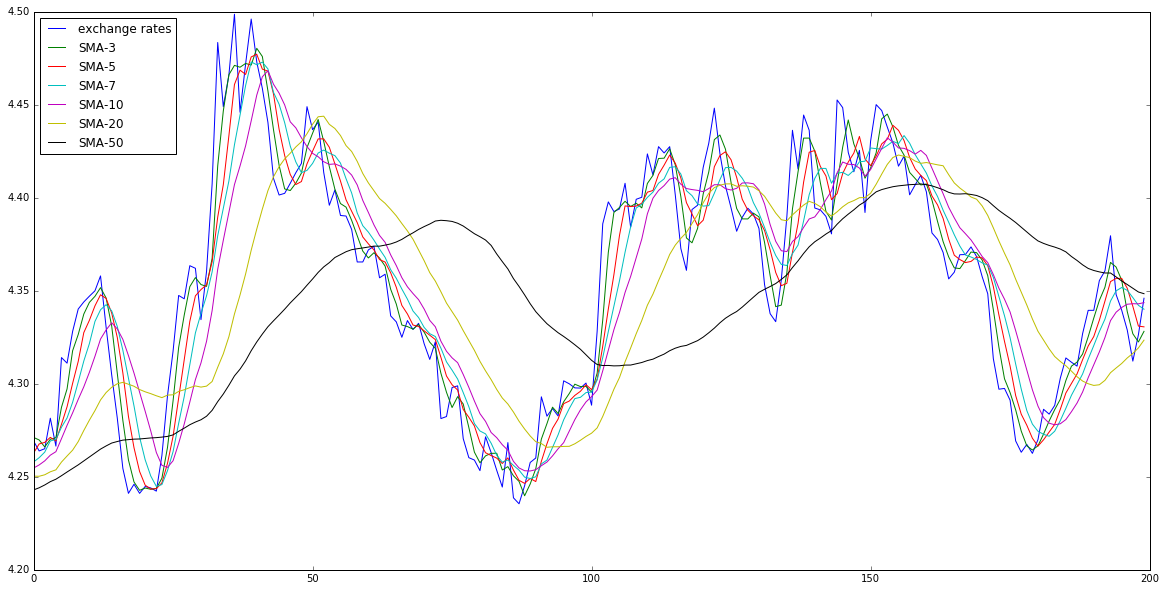

In [292]:
plt.figure(figsize=(20,10))

# plot unchanged history of exchange rates
plt.plot(recent_exchange_rates)

legend = []
legend.append('exchange rates')
for window in sma_windows:
    plt.plot(df_sma[window][-last_days_to_observe:].values)
    legend.append('SMA-{}'.format(window))
    
# plot dynamically created legend
plt.legend(legend, loc='upper left')

Conclusion: The SMA-3, SMA-5, SMA-7, and SMA-10 are the best dataset in terms of mirroring exchange rates

#### Calculate intersection points between various SMA data ranges

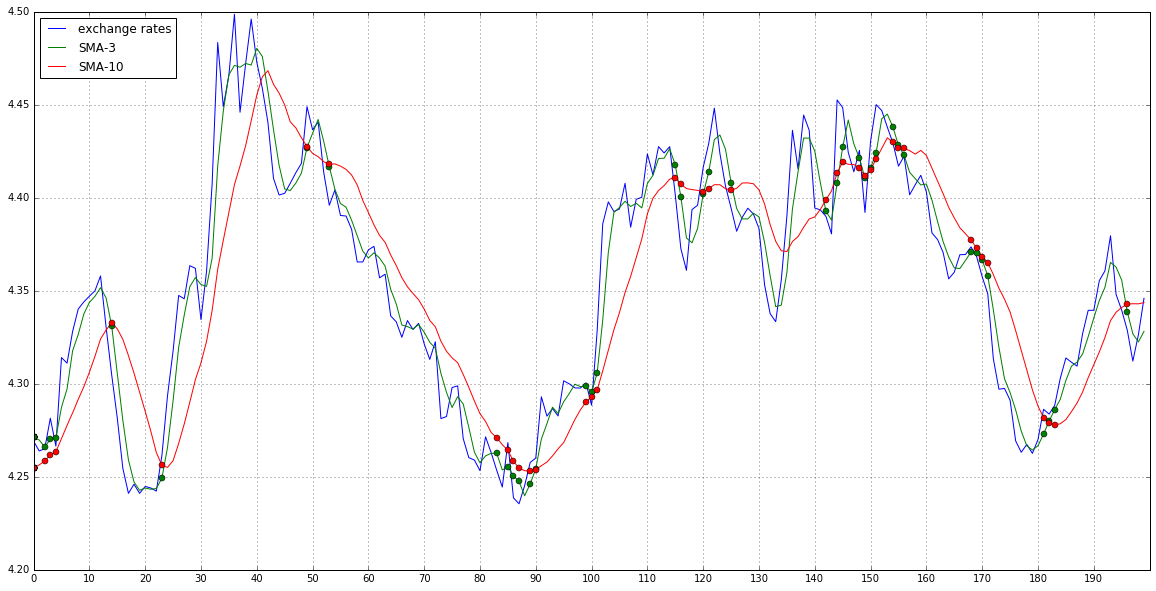

In [293]:
def plot_pair(pair):
    window1 = pair[0]
    window2 = pair[1]
    # get SMA values for interesting windows
    sma1 = df_sma[window1][-last_days_to_observe:].values
    sma2 = df_sma[window2][-last_days_to_observe:].values
    # calculate crossing points between both value ranges
    intersection_points = np.argwhere(np.isclose(sma1, sma2, atol=0.01)).reshape(-1)
    # plot
    plt.plot(sma1)
    plt.plot(sma2)
    plt.plot(intersection_points, sma1[intersection_points], 'go')
    plt.plot(intersection_points, sma2[intersection_points], 'ro')
    plt.xticks(np.arange(0, last_days_to_observe, 10))
    # return
    return list(intersection_points)[::2]


# set up plotting parameters
plt.figure(figsize=(20,10))
plt.grid(True)

plt.plot(recent_exchange_rates)    
comparison_pair = (3, 10)
intersection_points = plot_pair(comparison_pair)
plt.legend(['exchange rates', "SMA-{}".format(comparison_pair[0]), "SMA-{}".format(comparison_pair[1])], loc='upper left')


### What's wrong with intersection between 40-50??

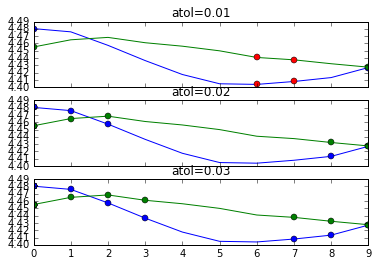

In [294]:
x1 = 40
x2 = 50

test_sma_1 = df_sma[3][-200+x1:-200+x2].values
test_sma_2 = df_sma[10][-200+x1:-200+x2].values

intpoints_v1 = np.argwhere(np.isclose(test_sma_1, test_sma_2, atol=0.01)).reshape(-1)
intpoints_v2 = np.argwhere(np.isclose(test_sma_1, test_sma_2, atol=0.02)).reshape(-1)
intpoints_v3 = np.argwhere(np.isclose(test_sma_1, test_sma_2, atol=0.03)).reshape(-1)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.set_title("atol=0.01")
ax1.plot(test_sma_1)
ax1.plot(test_sma_2)
ax1.plot(intpoints_v1, test_sma_1[intpoints_v1], 'bo')
ax1.plot(intpoints_v1, test_sma_2[intpoints_v1], 'go')
ax1.plot(6, test_sma_1[6], 'ro')
ax1.plot(7, test_sma_1[7], 'ro')
ax1.plot(6, test_sma_2[6], 'ro')
ax1.plot(7, test_sma_2[7], 'ro')

ax2.set_title("atol=0.02")
ax2.plot(test_sma_1)
ax2.plot(test_sma_2)
ax2.plot(intpoints_v2, test_sma_1[intpoints_v2], 'bo')
ax2.plot(intpoints_v2, test_sma_2[intpoints_v2], 'go')

ax3.set_title("atol=0.03")
ax3.plot(test_sma_1)
ax3.plot(test_sma_2)
ax3.plot(intpoints_v3, test_sma_1[intpoints_v3], 'bo')
ax3.plot(intpoints_v3, test_sma_2[intpoints_v3], 'go')


Conclusion: This way of finding intersecting points is not acceptable for our case.

In [295]:
#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#
# Stolen directly from http://www.cs.mun.ca/~rod/2500/notes/numpy-arrays/numpy-arrays.html
#
from numpy import *
def perp(a):
    b = empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b


# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1, a2, b1, b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = dot( dap, db)
    num = dot( dap, dp )
    return (num / denom.astype(float))*db + b1


def get_intersection_point_between_points(a1, a2, b1, b2):
    intersection_point = seg_intersect(a1, a2, b1, b2)    
    intersection_point_x = intersection_point[0]
    
    if intersection_point_x >= max([a1[0], b1[0]]) and intersection_point_x <= min([a2[0], b2[0]]):
        return intersection_point
    else:
        return [nan, nan] 

    
def get_intersection_points(x_values, y_values_1, y_values_2):
    intersection_points = []
    for x in x_values[:-1]:
        point = get_intersection_point_between_points(array([x, y_values_1[x]]),     \
                                                      array([x+1, y_values_1[x+1]]), \
                                                      array([x, y_values_2[x]]),     \
                                                      array([x+1, y_values_2[x+1]]))       
        if not math.isnan(point[0]):
            intersection_points.append(point)    
    return intersection_points
                        
            
# some test cases
#p1_1 = array([ 0, 4.46613333])
#p1_2 = array([ 1, 4.4712])
#p2_1 = array([ 0, 4.39197])
#p2_2 = array([ 1, 4.40709])
#print(seg_intersect(p1_1, p1_2, p2_1, p2_2))
#print(get_intersection_point_in_range(p1_1, p1_2, p2_1, p2_2))


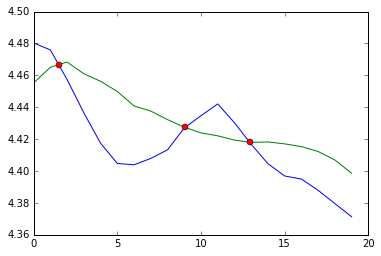

In [296]:
x1 = 40
x2 = 60

x_values = list(range(0, x2-x1, 1))
test_sma_1 = df_sma[3][-200+x1:-200+x2].values
test_sma_2 = df_sma[10][-200+x1:-200+x2].values

test_sma_1_flattened = [item for sublist in test_sma_1 for item in sublist]
test_sma_2_flattened = [item for sublist in test_sma_2 for item in sublist]

intpoints_v1 = get_intersection_points(x_values, test_sma_1_flattened, test_sma_2_flattened)

f, ax1 = plt.subplots(1, sharex=True, sharey=True)
ax1.plot(test_sma_1)
ax1.plot(test_sma_2)

for intpoint in intpoints_v1:
    ax1.plot(intpoint[0], intpoint[1], 'ro')



### Now we have better algorithm of finding intersection points, so it's time redraw 

In [297]:
def plot_pair_v2(pair):
    window1 = pair[0]
    window2 = pair[1]
    # get SMA values for interesting windows
    sma1 = df_sma[window1][-last_days_to_observe:-1].values
    sma2 = df_sma[window2][-last_days_to_observe:-1].values
      
    # make extra calculations that simplify process of finding crossing points
    sma_1_flattened = [item for sublist in sma1 for item in sublist]
    sma_2_flattened = [item for sublist in sma2 for item in sublist]
    x_values = range(0, len(sma_1_flattened), 1)
    
    # calculate crossing points between both value ranges
    intersection_points = get_intersection_points(x_values, sma_1_flattened, sma_2_flattened)
    
    # plot
    plt.xticks(np.arange(0, last_days_to_observe, 10))

    plt.plot(sma1)
    plt.plot(sma2)
    for intpoint in intersection_points:
        plt.plot(intpoint[0], intpoint[1], 'ro')
       
    # return all interesction points
    return intersection_points

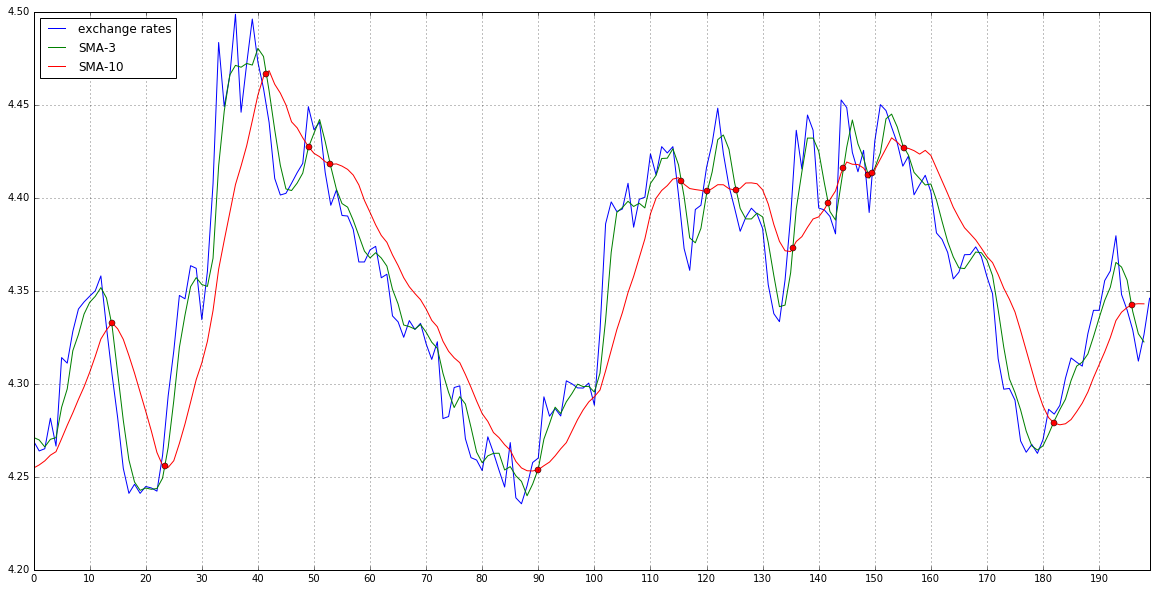

In [298]:
# set up plotting parameters
plt.figure(figsize=(20,10))
plt.grid(True)

plt.plot(recent_exchange_rates)    
comparison_pair = (3, 10)
intersection_points = plot_pair_v2(comparison_pair)
plt.legend(['exchange rates', "SMA-{}".format(comparison_pair[0]), "SMA-{}".format(comparison_pair[1])], loc='upper left')

### Determine exchange rates

INFORMATION: Exchange rates are determined for "a next business day", so it's first available day once we are know that the crossing took place

In [299]:
#print("Exact intersection points between SMA-{} and SMA-{}".format(comparison_pair[0], comparison_pair[1]))
#print(intersection_points)
#print()
print("Intersection points between SMA-{} and SMA-{} changed to indicate next business day".format(comparison_pair[0], \
                                                                                                   comparison_pair[1]))
for i in intersection_points:
    original_x = i[0]
    next_business_day = int(original_x) + 1
    print("{} ==> date: {}, exchange rate: {}".format(next_business_day, \
                                                      recent_dates[next_business_day], \
                                                      recent_exchange_rates[next_business_day]))
print()

Intersection points between SMA-3 and SMA-10 changed to indicate next business day
14 ==> date: 2015-12-17, exchange rate: 4.3048
24 ==> date: 2016-01-04, exchange rate: 4.2935
42 ==> date: 2016-01-29, exchange rate: 4.4405
50 ==> date: 2016-02-10, exchange rate: 4.4366
53 ==> date: 2016-02-15, exchange rate: 4.396
90 ==> date: 2016-04-07, exchange rate: 4.2601
116 ==> date: 2016-05-16, exchange rate: 4.3727
121 ==> date: 2016-05-23, exchange rate: 4.4293
126 ==> date: 2016-05-31, exchange rate: 4.382
136 ==> date: 2016-06-14, exchange rate: 4.4363
142 ==> date: 2016-06-22, exchange rate: 4.39
145 ==> date: 2016-06-27, exchange rate: 4.4485
149 ==> date: 2016-07-01, exchange rate: 4.3921
150 ==> date: 2016-07-04, exchange rate: 4.4304
156 ==> date: 2016-07-12, exchange rate: 4.4224
182 ==> date: 2016-08-18, exchange rate: 4.2837
196 ==> date: 2016-09-07, exchange rate: 4.3289

